# Deep Q-Network (DQN)

In [7]:
import numpy as np
from torchinfo import summary

import ale_py
import gymnasium as gym

import sys
sys.path.append("./dqn") 
import evaluation
from atari_env import make_env
from q_network import CNNQNetwork
from dqn_cnn import run_dqn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## preprocessing

In [3]:
env_id = "ALE/Breakout-v5"
env = make_env(env_id, render_mode="rgb_array")
env.observation_space

Box(0.0, 1.0, (4, 84, 84), float32)

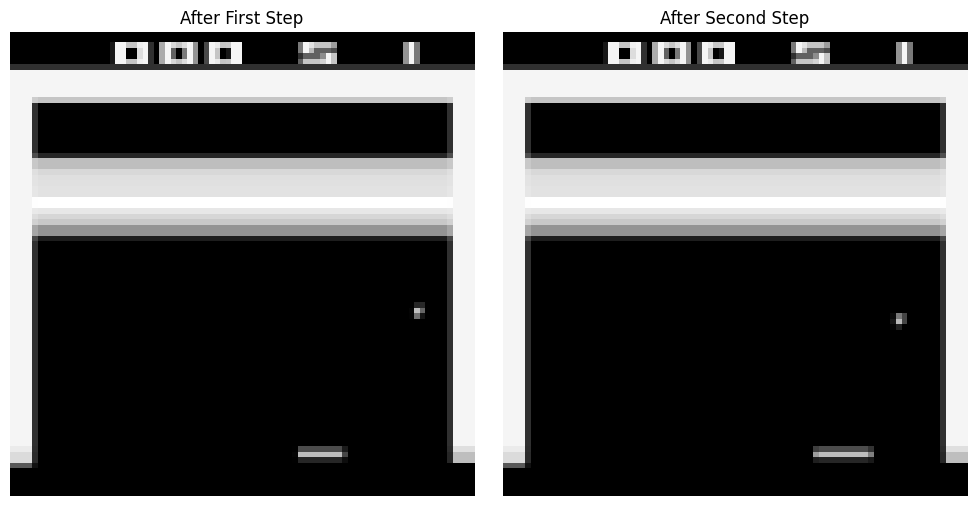


Verifying frame shifts:
Frame 0 of second step should equal Frame 1 of first step: True
Frame 1 of second step should equal Frame 2 of first step: True
Frame 2 of second step should equal Frame 3 of first step: True
New frame in second step should be different from all previous: True


In [6]:
import matplotlib.pyplot as plt

obs, _ = env.reset()

# Take first step
obs1, _, _, _, _ = env.step(env.action_space.sample())

# Take second step
obs2, _, _, _, _ = env.step(env.action_space.sample())

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display first frame (obs1[-1])
axes[0].imshow(obs1[-1], cmap='gray')
axes[0].set_title("After First Step")
axes[0].axis('off')  # Hide axes for cleaner look

# Display second frame (obs2[-1])
axes[1].imshow(obs2[-1], cmap='gray')
axes[1].set_title("After Second Step")
axes[1].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Verify frames have shifted
print("\nVerifying frame shifts:")
print(f"Frame 0 of second step should equal Frame 1 of first step: {np.allclose(obs2[0], obs1[1])}")
print(f"Frame 1 of second step should equal Frame 2 of first step: {np.allclose(obs2[1], obs1[2])}")
print(f"Frame 2 of second step should equal Frame 3 of first step: {np.allclose(obs2[2], obs1[3])}")
print(f"New frame in second step should be different from all previous: {not np.any(np.allclose(obs2[3], obs1, atol=0.1))}")

env.close()

## Q-Network with CNN

In [17]:
env_id = "ALE/Pong-v5"
env = make_env(env_id, render_mode="rgb_array")

obs, _ = env.reset()
q_net = CNNQNetwork(env.observation_space, env.action_space)

# Get the correct input shape from the environment
input_shape = env.observation_space.shape

# Print model summary with correct input shape
print(f"\nModel Summary for input shape: {(1,) + input_shape}")
model_summary = summary(
    q_net,
    input_size=(1,) + input_shape,  # Add batch dimension
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    verbose=0
)
print(model_summary)


Model Summary for input shape: (1, 4, 84, 84)
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
CNNQNetwork                              [1, 4, 84, 84]            [1, 6]                    --                        --                        --
├─Sequential: 1-1                        [1, 4, 84, 84]            [1, 6]                    --                        --                        --
│    └─Conv2d: 2-1                       [1, 4, 84, 84]            [1, 32, 20, 20]           8,224                     [8, 8]                    3,289,600
│    └─ReLU: 2-2                         [1, 32, 20, 20]           [1, 32, 20, 20]           --                        --                        --
│    └─Conv2d: 2-3                       [1, 32, 20, 20]           [1, 64, 9, 9]             32,832                    [4, 4]                    2,659,392
│    └─ReLU: 2-4                         [1,

## Train DQN agent with target network

In [ ]:
env_id = "ALE/Pong-v5"
# when in cpu, around 35mins
q_net = run_dqn(
    env_id= env_id,
    n_timesteps=1000_000,     # 
    learning_starts=5_000,     # later learning starts
    exploration_fraction=0.5, # slower decay over 50% of timesteps
    replay_buffer_size=100_000,
    learning_rate=5e-4,
    batch_size=128,
    update_interval = 4,
    target_network_update_interval=1000,
    evaluation_interval=100_000,
    gamma=0.99,
)

: 

### Visualize the trained agent

In [28]:
import torch

eval_env = make_env("ALE/Pong-v5", render_mode="rgb_array")
n_eval_episodes = 2
eval_exploration_rate = 0.0
video_name = f"DQN_pong"

# Optional: load checkpoint
q_net = CNNQNetwork(env.observation_space, env.action_space)
q_net.load_state_dict(torch.load("./logs/q_net_checkpoint_ALE_Pong-v5_100000.pth"))

evaluation.evaluate_policy(
    eval_env,
    q_net,
    n_eval_episodes,
    eval_exploration_rate=eval_exploration_rate,
    video_name=video_name,
)


Mean episode reward: -14.50 +/- 0.50


(-14.5, 0.5)

## Training DQN agent on flappy bird:

You can go in the [GitHub repo](https://github.com/araffin/flappy-bird-gymnasium/tree/patch-1) to learn more about this environment.

<div>
    <img src="https://raw.githubusercontent.com/markub3327/flappy-bird-gymnasium/main/imgs/dqn.gif" width="300"/>
</div>


In [ ]:
!pip install "flappy-bird-gymnasium @ git+https://github.com/araffin/flappy-bird-gymnasium@patch-1"

In [ ]:
import flappy_bird_gymnasium  # noqa: F401

In [ ]:
env_id = "FlappyBird-v0"

q_net = run_dqn(
    env_id=env_id,
    replay_buffer_size=100_000,
    # Note: you can remove the target network
    # by setting target_network_update_interval=1
    target_network_update_interval=250,
    learning_starts=10_000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.03,
    exploration_fraction=0.1,
    n_timesteps=500_000,
    update_interval=4,
    learning_rate=1e-3,
    batch_size=128,
    gamma=0.98,
    n_eval_episodes=5,
    evaluation_interval=50000,
    n_hidden_units=256,
    # No exploration during evaluation
    # (deteministic policy)
    eval_exploration_rate=0.0,
    seed=2023,
    eval_render_mode=None,
)

### Record a video of the trained agent

In [ ]:
eval_env = gym.make(env_id, render_mode="rgb_array")
n_eval_episodes = 3
eval_exploration_rate = 0.00
video_name = f"DQN_{env_id}"


# Optional: load checkpoint
q_net = QNetwork(eval_env.observation_space, eval_env.action_space, n_hidden_units=256)
# Convert weights from float32 to float64 to match flappy bird obs
q_net.double()
q_net.load_state_dict(th.load("../logs/q_net_checkpoint_FlappyBird-v0_200000.pth"))

evaluation.evaluate_policy(
    eval_env,
    q_net,
    n_eval_episodes,
    eval_exploration_rate=eval_exploration_rate,
    video_name=video_name,
)

show_videos(video_folder, prefix=video_name)

### Going further

- analyse the learned q-values
- explore different value for the target update, use soft update instead of hard-copy
- experiment with Huber loss (smooth l1 loss) instead of l2 loss (mean squared error)
- play with different environments
- implement a CNN to play flappybird/pong from pixels (need to stack frames)
- implement DQN extensions (double Q-learning, prioritized experience replay, ...)

## Conclusion

In this notebook, you have seen how to implement the DQN algorithm (update rule and training loop) using all the components from part I (replay buffer, epsilon-greedy exploration strategy, Q-Network, ...).